# Preliminary Experiments to Analyse Task Decompositions in MoE Model for combined FMINST and MNIST Dataset

In this notebook we run experiments, as detailed in the figure below, to analyse task decomposition in MoE models and if there is a training or error advantage for bad decompositions.

![](../figures/exp_flow.png)

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cpu


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import *

device cpu


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. They are in the folder \\$root/models/pre_trained/fmnist . You can either copy them to the \\$root/models folder or load them directly from the pre_trained folder (just make sure you use the correct folder).

## Combining FMNIST and MNIST datasets. We take 6 classes from FMNIST, which are 't-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal' and 6 classes from MNIST, which are '4','5','6','7','8','9'.

In [6]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures'
model_path = '../models'
results_path = '../results'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)        

In [7]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# increment the target by 2: used when combining fmnist and mnist targets that have the 
# same labels
def target_transform(target):
    return target+2

In [8]:
# Set train and test size
trainsize = 10000
testsize = 2000
batchsize = 64

In [9]:
fmnist_trainset = torchvision.datasets.FashionMNIST('data', transform=transform, train=True, download=True)

In [10]:
fmnist_testset = torchvision.datasets.FashionMNIST('data',transform=transform, train=False)

In [11]:
mnist_trainset = torchvision.datasets.MNIST('data', transform=transform, target_transform=target_transform, train=True, download=True)

In [12]:
mnist_testset = torchvision.datasets.MNIST('data',transform=transform, target_transform=target_transform, train=False)

In [13]:
classes_fmnist = ['t-shirt', 'Trouser', 'Pullover','Dress','Coat','Sandal',
                  'Shirt','Sneaker','Bag','Ankle boot']
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

# Combined fmnist and mnist classes. 
classes_fmnist_mnist = classes_fmnist[0:6]+[str(n) for n in range(4,10)]
print('classes_fmnist_mnist', classes_fmnist_mnist)

classes_fmnist_mnist ['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', '4', '5', '6', '7', '8', '9']


In [14]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, data):
    print(classes_sub)
    start = 0
    labels = data.targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [15]:
# Get the data for first 6 classes of fmnist dataset
fmnist_indices_train = filter_classes(classes_fmnist[0:6], classes_fmnist, int(trainsize/2), fmnist_trainset)
fmnist_indices_test = filter_classes(classes_fmnist[0:6], classes_fmnist, int(testsize/2), fmnist_testset)

['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']
['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']


In [16]:
# Get the data for last 6 classes of fmnist dataset
mnist_indices_train = filter_classes(classes_mnist[4:], classes_mnist, int(trainsize/2), mnist_trainset)
mnist_indices_test = filter_classes(classes_mnist[4:], classes_mnist, int(testsize/2), mnist_testset)

['4', '5', '6', '7', '8', '9']
['4', '5', '6', '7', '8', '9']


In [17]:
# Create the combined dataset with fmnist and mnist classes
trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_trainset,fmnist_indices_train), 
                         torch.utils.data.Subset(mnist_trainset,mnist_indices_train)])
testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_testset,fmnist_indices_test), 
                        torch.utils.data.Subset(mnist_testset,mnist_indices_test)])
train_size = len(fmnist_indices_train)+len(mnist_indices_train)
test_size = len(fmnist_indices_test)+len(mnist_indices_test)
print("Train size", train_size)
print("Test size", test_size)

Train size 10000
Test size 2000


In [18]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=1, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=testsize,
                                         shuffle=True, num_workers=1, pin_memory=True)

In [19]:
num_classes = len(classes_fmnist_mnist)

In [20]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([64, 1, 28, 28])
Data samples


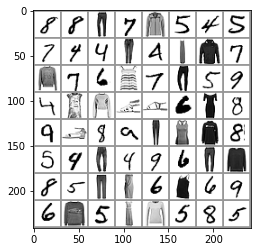

In [21]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
# create grid of images
img_grid = torchvision.utils.make_grid(images)

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Define expert and gate networks

In [22]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=1):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=32) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
                
        return t

In [23]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)

        self.fc1 = nn.Linear(in_features=1*12*12, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [24]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers, channels=1):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes, channels))
    return nn.ModuleList(models)

## Initialize configurations and helper functions

In [25]:
# Compute accuracy of the model
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [26]:
# Generate the string reprensentation of the class split used for pre-training the experts
def classes_per_expert_str(classes_per_expert):
    buffer_str = ''
    for labels in classes_per_expert:
        buffer = "_".join(str(labels).replace('[','').replace(']','').replace(',','_').replace(" ",'')).replace('_','')
        buffer_str += buffer+'_'
    buffer_str = buffer_str.strip('_')
    return buffer_str

## Experiments

### Experiment 1: Train MoE expectation model with un-trained experts

#### The MoE model is first trained with un-trained experts. The gate trained in this model is then used to train a new model with new experts with (a) default parameters and (b) parameters initialized to parameters of the experts that the gate was trained with. 

#### Jump to [Results](#Results) if you just want to run pre-trained models and see the results

In [58]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_scratch'
# Model with gate parameters fixed to learnt gate parameters from model_1 and experts initialized to 
# the same initial parameters as experts from model_1 before they were trained
model_2 = 'fmnist_mnist_pretrained_gate_scratch_same_wts'
# Model with gate parameters fixed to learnt gate parameters from model_1 and experts initialized to 
# default parameters
model_3 = 'fmnist_mnist_pretrained_gate_scratch_rand_wts'

In [59]:
total_experts = 6

In [60]:
num_epochs = 20

In [61]:
T = [1.0]*num_epochs

In [62]:
# Train models model_1, model_2 and model_3 for 10 runs
n_runs = 10
n_run_models_1 = []
n_run_models_2 = []
n_run_models_3 = []
for n_run in range(1, n_runs+1):
    print('RUN', n_run)
    models = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),'experts':{}},
        }

    models_gate_pretrained_same_wts = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),'experts':{}},
        }

    models_gate_pretrained_rand_wts = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),'experts':{}},
        }

    saved_experts = {}

    # Build model with un-trained experts
    for key, val in models.items():
        print('Model:', key, total_experts, 'Experts')
        print('Building model with un-trained experts')
        # copy and save the expert models to save the parameters
        expert_models_copy = experts(total_experts, num_classes).to(device)

        # copy and save the expert models to save the parameters
        expert_models = deepcopy(expert_models_copy)
        saved_experts[key] = expert_models_copy

        gate_model = gate_layers(total_experts).to(device)

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                 experts=expert_models, gate=gate_model)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    # Save all the trained models
    plot_file = generate_plot_file(model_1, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
        
    n_run_models_1.append(models)
        
    torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
    n_run_models_1 = []


    # train new experts with pre-trained gate fom model_1 above with same parameters as the 
    # experts it was trained from
    for key, val in models_gate_pretrained_same_wts.items():
        print('Building model with pre-trained gate and new experts initialized to same parameters as experts used to train the gate')
        
        # copy parameters of the experts
        expert_models = deepcopy(saved_experts[key])

        # load the pre-trained gate model
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the parameters of the gate
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    # Save all the trained models
    plot_file = generate_plot_file(model_2, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_run_models_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
        
    n_run_models_2.append(models_gate_pretrained_same_wts)
        
    torch.save(n_run_models_2,open(os.path.join(model_path, plot_file),'wb'))
    n_run_models_2 = []

    # Train new experts with pre-trained gate fom model_1 above with default parameters
    for key, val in models_gate_pretrained_rand_wts.items():
        
        print('Building model with pre-trained gate and new experts initialized to default parameters')

        # initialize the expert parameters to default parameters
        expert_models = experts(total_experts, num_classes).to(device)

        # load pre-trained gate
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the gate parameters
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)        
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}
    
    # Save all the trained models
    plot_file = generate_plot_file(model_3, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_run_models_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
        
    n_run_models_3.append(models_gate_pretrained_rand_wts)
        
    torch.save(n_run_models_3,open(os.path.join(model_path, plot_file),'wb'))
    n_run_models_3 = []


RUN 1
Model: moe_expectation_model 6 Experts
Building model with un-trained experts
model params: 31600
epoch 0 training loss 1.68 , training accuracy 0.43 , test accuracy 0.67
epoch 1 training loss 0.70 , training accuracy 0.76 , test accuracy 0.77
epoch 2 training loss 0.46 , training accuracy 0.85 , test accuracy 0.82
epoch 3 training loss 0.37 , training accuracy 0.88 , test accuracy 0.85
epoch 4 training loss 0.33 , training accuracy 0.89 , test accuracy 0.85
epoch 5 training loss 0.30 , training accuracy 0.90 , test accuracy 0.87
epoch 6 training loss 0.28 , training accuracy 0.91 , test accuracy 0.87
epoch 7 training loss 0.27 , training accuracy 0.91 , test accuracy 0.87
epoch 8 training loss 0.25 , training accuracy 0.91 , test accuracy 0.88
epoch 9 training loss 0.25 , training accuracy 0.92 , test accuracy 0.89
epoch 10 training loss 0.23 , training accuracy 0.92 , test accuracy 0.88
epoch 11 training loss 0.22 , training accuracy 0.92 , test accuracy 0.89
epoch 12 training 

### Experiment 2: Train MoE expectation model with pre-trained experts

#### The MoE model is first trained with pre-trained experts trained on pre-defined data splits. The gate trained in this model is then used to train a new model with new experts with (a) default parameters and (b) parameters initialized to parameters of the experts that the gate was trained with. 

#### Pre-defined data splits for the fmnist data are a set of 3 pairs of clothing items. 3 of the 6 experts are trained on data samples of only one of these pairs. Similarly the pre-defined data splits for the mnist data are a set of 3 pairs of digits. The remaining 3 of the 6 experts are trained on data samples of only one of these pairs. 

### Jump to [Results](#Results) if you just want to run pre-trained models and see the results

In [69]:
total_experts = 6

In [70]:
num_epochs = 20

In [71]:
def process_split(split):
    sorted_tuples = []
    for i in range(0,len(split),2):
        sorted_tuples.append(sorted(split[i:i+2]))
    return sorted_tuples

In [72]:
# Generate random splits of the classes of the dataset
def select_classes_per_expert(classes=[], num_splits = 5):
    splits = []
    for i in range(num_splits):
        split = []
        while not split or split in splits:
            for j in range(len(classes)):
                selected_class = np.random.choice(classes)
                while selected_class in split:
                    selected_class = np.random.choice(classes)
                split.append(selected_class)
            split = process_split(split)    
        splits.append(split)
    return splits

In [73]:
# Example random split of data
classes_per_expert_list = select_classes_per_expert(classes=range(12))

classes_per_expert_list

[[[9, 10], [3, 5], [6, 8], [0, 7], [2, 4], [1, 11]],
 [[1, 2], [3, 7], [0, 4], [8, 9], [5, 11], [6, 10]],
 [[1, 9], [10, 11], [0, 4], [5, 7], [2, 8], [3, 6]],
 [[5, 10], [2, 7], [1, 11], [0, 9], [4, 8], [3, 6]],
 [[8, 9], [3, 5], [0, 2], [4, 11], [7, 10], [1, 6]]]

In [74]:
# This is the split used in the paper
classes_per_expert_list = [[[0,1], [2,3], [4,5], [6,7], [8,9], [10,11]],
                           [[0,3], [1,4], [2,5], [6,9], [7,11], [8,10]],
                           [[0,5], [1,2], [3,4], [6,8], [7,10],[9,11]]]

In [83]:
# Pre-defined class split among experts. 0-4 classes are from fmnist and 5-9 are from mnist

class_expert_map = []
for cpe in classes_per_expert_list:
    entry = {c[0]:c[1] for c in cpe}
    class_expert_map.append(entry)

In [75]:
# Function to pre-train experts according to the split
def train_experts(masks, total_experts, num_classes_per_expert, num_classes, num_epochs, batch_size,
                  trainset, testset):
    expert_models_copy = experts(total_experts, num_classes).to(device)
    expert_models = deepcopy(expert_models_copy)
    
    curr_trainset = fmnist_trainset
    count = 0
    for mask, expert in zip(masks, expert_models):       
        print('Classes', mask)
        indices = []
        for m in mask:
            if count >= 3:
                m -= 2
            indices += torch.where(curr_trainset.targets[0:train_size] == m)[0]
        
        trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(torch.utils.data.Subset(curr_trainset, range(0, train_size)), indices), 
                                          batch_size=batch_size,
                                          shuffle=True)
        
        optimizer_expert = optim.Adam(expert.parameters(), lr=0.001, amsgrad=False)        
        
        loss_criterion = cross_entropy_loss()
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                outputs = expert(inputs)

                optimizer_expert.zero_grad()
                loss = loss_criterion(outputs, None, None, labels)

                loss.backward()

                optimizer_expert.step()

                running_loss += loss.item()

                outputs = expert(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1

            print('epoch %d' % epoch,
                  'training loss %.2f' % (running_loss/num_batches),
                   ', training accuracy %.2f' % (train_running_accuracy/num_batches),
                   )
        count += 1
        if count == 3:
            curr_trainset = mnist_trainset
            
    pre_trained_expert = 'fmnist_mnist_pre_trained'
    plot_file = generate_plot_file(pre_trained_expert, specific=str(num_classes)+'_'+str(total_experts)+'_'+classes_per_expert_str(masks)+'_expert_model.pt')
    print(plot_file)
    torch.save([expert_models, expert_models_copy],open(os.path.join(model_path, plot_file),'wb'))
    return expert_models, expert_models_copy

In [76]:
# Pre-train experts on pre-defined splits
for class_per_expert in classes_per_expert_list:
    print(class_per_expert)
    expert_models, expert_models_copy = train_experts(class_per_expert, total_experts, [2]*total_experts, num_classes, num_epochs, batchsize,
                      trainset, testset)

[[0, 3], [1, 4], [2, 5], [6, 9], [7, 11], [8, 10]]
Classes [0, 3]
epoch 0 training loss 1.84 , training accuracy 0.41
epoch 1 training loss 0.86 , training accuracy 0.49
epoch 2 training loss 0.71 , training accuracy 0.52
epoch 3 training loss 0.69 , training accuracy 0.52
epoch 4 training loss 0.65 , training accuracy 0.64
epoch 5 training loss 0.51 , training accuracy 0.84
epoch 6 training loss 0.34 , training accuracy 0.87
epoch 7 training loss 0.27 , training accuracy 0.89
epoch 8 training loss 0.24 , training accuracy 0.91
epoch 9 training loss 0.22 , training accuracy 0.91
epoch 10 training loss 0.22 , training accuracy 0.91
epoch 11 training loss 0.21 , training accuracy 0.92
epoch 12 training loss 0.20 , training accuracy 0.92
epoch 13 training loss 0.20 , training accuracy 0.92
epoch 14 training loss 0.19 , training accuracy 0.92
epoch 15 training loss 0.19 , training accuracy 0.92
epoch 16 training loss 0.19 , training accuracy 0.92
epoch 17 training loss 0.19 , training accu

#### NOTE: We have provided expert models already pre-trained with the above class splits

In [77]:
# Model trained with pre-trained experts
model_4 ='fmnist_mnist_pretrained_gate_prechosen'
# Model with gate parameters fixed to learnt gate parameters from model_4 and experts initialized to 
# the same initial parameters as experts from model_4 before they were trained
model_5 = 'fmnist_mnist_pretrained_gate_prechosen_same_wts'
# Model with gate parameters fixed to learnt gate parameters from model_4 and experts initialized to default parameters
model_6 = 'fmnist_mnist_pretrained_gate_prechosen_rand_wts'

In [78]:
total_experts = 6

In [79]:
num_epochs = 20

In [84]:
# Train models model_4, model_5 and model_6 for the different splits of the digits shown above.
pre_trained_expert = 'fmnist_mnist_pre_trained'
n_split_models_1 = []
n_split_models_2 = []
n_split_models_3 = []
for classes_per_expert in classes_per_expert_list:
    print('RUN for split:', classes_per_expert_str(classes_per_expert))

    models = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),'experts':{}},
        }

    models_gate_pretrained_same_wts = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),'experts':{}},
        }

    models_gate_pretrained_rand_wts = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),'experts':{}},
        }

    # Load the pre-trained experts for the corresponding split
    plot_file = generate_plot_file(pre_trained_expert, specific=str(num_classes)+'_'+str(total_experts)+'_'+classes_per_expert_str(classes_per_expert)+'_expert_model.pt')
    expert_models, expert_models_copy = torch.load(os.path.join(model_path, plot_file))
    
    for i, expert in enumerate(expert_models):
        for param in expert.parameters():
            param.requires_grad = False
    

    for key, val in models.items():
        print('Model:', key, total_experts, 'Experts')
        print('Building model with pre-trained experts')

        expert_models = expert_models.to(device)

        gate_model = gate_layers(total_experts).to(device)

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))
        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    plot_file = generate_plot_file(model_4, specific = str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_split_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
        
    n_split_models_1.append(models)
        
    torch.save(n_split_models_1,open(os.path.join(model_path, plot_file),'wb'))
    n_split_models_1 = []



    for key, val in models_gate_pretrained_same_wts.items():

        print('Building model with pre-trained gate and new experts initialized to same parameters as experts used to train the gate')

        # copy parameters of the experts
        expert_models = expert_models_copy.to(device)

        # load the pre-trained gate
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the gate parameters
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    plot_file = generate_plot_file(model_5, specific = str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_split_models_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
        
    n_split_models_2.append(models_gate_pretrained_same_wts)
        
    torch.save(n_split_models_2,open(os.path.join(model_path, plot_file),'wb'))
    n_split_models_2 = []


    for key, val in models_gate_pretrained_rand_wts.items():
        print('Building model with pre-trained gate and new experts initialized to default parameters')

        # initialize the expert parameters to default parameters
        expert_models = experts(total_experts,  num_classes).to(device)

        # load the pre-trained gate
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the gate parameters
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}
    plot_file = generate_plot_file(model_6, specific = str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_split_models_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
        
    n_split_models_3.append(models_gate_pretrained_rand_wts)
        
    torch.save(n_split_models_3,open(os.path.join(model_path, plot_file),'wb'))
    n_split_models_3 = []

    

RUN for split: 01_23_45_67_89_1011
Model: moe_expectation_model 6 Experts
Building model with pre-trained experts
model params: 22912
epoch 0 training loss 0.90 , training accuracy 0.71 , test accuracy 0.82
epoch 1 training loss 0.41 , training accuracy 0.86 , test accuracy 0.84
epoch 2 training loss 0.35 , training accuracy 0.88 , test accuracy 0.86
epoch 3 training loss 0.31 , training accuracy 0.90 , test accuracy 0.86
epoch 4 training loss 0.28 , training accuracy 0.91 , test accuracy 0.88
epoch 5 training loss 0.26 , training accuracy 0.91 , test accuracy 0.89
epoch 6 training loss 0.24 , training accuracy 0.92 , test accuracy 0.89
epoch 7 training loss 0.22 , training accuracy 0.92 , test accuracy 0.89
epoch 8 training loss 0.21 , training accuracy 0.93 , test accuracy 0.89
epoch 9 training loss 0.20 , training accuracy 0.94 , test accuracy 0.90
epoch 10 training loss 0.19 , training accuracy 0.94 , test accuracy 0.89
epoch 11 training loss 0.17 , training accuracy 0.94 , test ac

## Results

### Collect the test error, train loss, mutual information $I(E;Y)$, sample entropy $H_s$ and expert usage entropy $H_u$ for all the models trained with MNIST dataset. Store the reuslts in the '../results/mnist_pretrained_results.csv' file.

In [40]:
import csv
from helper import moe_models

def collect_results(m, temps=[1.0], w_importance_range=[0.0], w_ortho_range=[0.0], 
                    w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                    total_experts=5, num_classes=10, num_epochs=20, 
                    testloader=None, fig_path=None, model_path=None, results_path=None, filename='fmnist_mnist_pretrained_results.csv'):
    
    filename = os.path.join(results_path, filename)
    
    if os.path.exists(filename):
        p = 'a'
    else:
        p = 'w'
        
    header = ['filename', 'test error','training loss', 'mutual information', 'sample entropy', 'experts usage']
    
    with open(filename, p) as f:
                
        writer = csv.writer(f)        
        
        if p == 'w':            
            writer.writerow(header)
        
        for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
            plot_file = generate_plot_file(m, w_importance=w_importance, w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff, 
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            models = torch.load(open(os.path.join(pre_trained_model_path, 'fmnist', plot_file),'rb'), map_location=device)
            for _ in range(len(models)):
                mod = models.pop()
                data = [plot_file]
                model = mod['moe_expectation_model']['experts'][total_experts]['model']
                history = mod['moe_expectation_model']['experts'][total_experts]['history']
                running_test_accuracy = 0.0
                running_entropy = 0.0
                num_batches = 0
                ey =  torch.zeros((num_classes, total_experts)).to(device)
                for test_inputs, test_labels in testloader:
                    test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
                    outputs = model(test_inputs)
                    running_test_accuracy += accuracy(outputs, test_labels)
                    
                    selected_experts = torch.argmax(model.gate_outputs, dim=1)
                    y = test_labels
                    e = selected_experts
                    for j in range(y.shape[0]):
                        ey[int(torch.argmax(model.expert_outputs[j,e[j],:])), int(e[j])] += 1

                    running_entropy += moe_models.entropy(model.gate_outputs)
                    
                    num_batches+=1
 
                mutual_EY,_,_,_ = moe_models.mutual_information(ey.detach())
    
                test_error = 1-(running_test_accuracy/num_batches)
                training_loss = history['loss'][-1]
                data.append(test_error.item())
                data.append(training_loss.item())
                data.append(mutual_EY.item())
                
                data.append(running_entropy.item()/num_batches)
                gate_probabilities_sum = torch.mean(model.gate_outputs, dim=0)            
                data.append(entropy(gate_probabilities_sum).item())
                
                writer.writerow(data)
            
            

#### Collect results for all the trained models

In [41]:
total_experts = 6
num_classes = 12
num_epochs = 20

In [43]:
models = ['fmnist_mnist_scratch', 'fmnist_mnist_pretrained_gate_scratch_same_wts', 'fmnist_mnist_pretrained_gate_scratch_rand_wts',
         'fmnist_mnist_pretrained_gate_prechosen', 'fmnist_mnist_pretrained_gate_prechosen_same_wts', 'fmnist_mnist_pretrained_gate_prechosen_rand_wts']
for m in models:
    collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                    testloader=testloader, model_path=model_path, results_path=results_path)

### Final results

#### These are the final average performance for each category of the trained MoE model.

In [44]:
import pandas as pd
filename = os.path.join(results_path, 'fmnist_mnist_pretrained_results.csv')
data = pd.read_csv(filename)

In [45]:
models = ['fmnist_mnist_scratch', 'fmnist_mnist_pretrained_gate_scratch_same_wts', 'fmnist_mnist_pretrained_gate_scratch_rand_wts',
         'fmnist_mnist_pretrained_gate_prechosen', 'fmnist_mnist_pretrained_gate_prechosen_same_wts', 'fmnist_mnist_pretrained_gate_prechosen_rand_wts']

final_results_file =  os.path.join(results_path, 'fmnist_mnist_final_pretrained_results.csv')

for m in models:
    row = data[data['filename'].str.startswith(m)].mean(numeric_only=True).to_frame().T
    row.insert(0,'filename',m)
    row.to_csv(final_results_file,mode='a', index=False, float_format='%.2f')

In [46]:
data = pd.read_csv(os.path.join(results_path, final_results_file))
data

,filename,test error,training loss,mutual information,sample entropy,experts usage
0,fmnist_mnist_scratch,0.10,0.18,1.75,0.13,1.88
1,filename,test error,training loss,mutual information,sample entropy,experts usage
2,fmnist_mnist_pretrained_gate_scratch_same_wts,0.11,0.18,1.77,0.13,1.88
3,filename,test error,training loss,mutual information,sample entropy,experts usage
4,fmnist_mnist_pretrained_gate_scratch_rand_wts,0.15,0.28,1.77,0.13,1.88
5,filename,test error,training loss,mutual information,sample entropy,experts usage
6,fmnist_mnist_pretrained_gate_prechosen,0.10,0.14,2.58,0.21,2.58
7,filename,test error,training loss,mutual information,sample entropy,experts usage
8,fmnist_mnist_pretrained_gate_prechosen_same_wts,0.10,0.13,2.58,0.21,2.58
9,filename,test error,training loss,mutual information,sample entropy,experts usage


### Plot the confusion matrix for the class predictions, for test data, of the MoE model trained with a linear gate and un-trained linear experts.

Model: fmnist_mnist_scratch_12_6_models.pt

Confusion matrix of predictions of the FMNIST test data by MoE expectation model


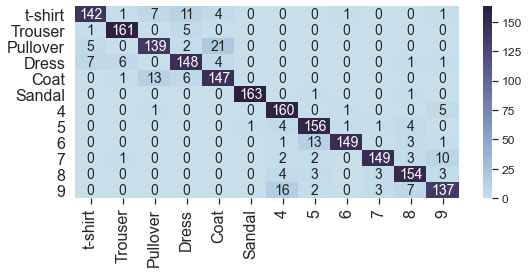


Experts used by the gate for classification of each digit


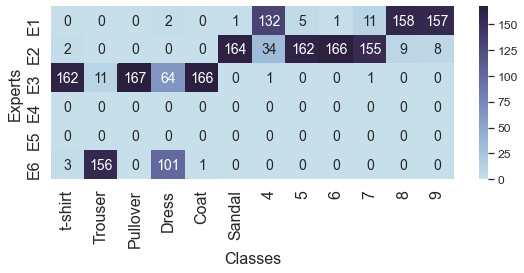

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_1 = 'fmnist_mnist_scratch'

m = model_1
n_runs = 5
n_run = 1
total_experts = 6
plot_file = generate_plot_file(m, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_scratch = torch.load(open(os.path.join(pre_trained_model_path, 'fmnist', plot_file),'rb'), map_location=device)
print('Model:', plot_file)

# Plotting for the model of the first run
model = models_scratch[0]
for e_key, e_val in model.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']
        moe_model.device = device
        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)

        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # plot the confusion matrix
        print('\nConfusion matrix of predictions of the FMNIST test data by MoE expectation model')
        sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), 
                    annot=True, ax=ax1, cmap=cmap, 
                    xticklabels=classes_fmnist_mnist, yticklabels=classes_fmnist_mnist, fmt='d',annot_kws={"size": 14})
        sns. set(font_scale=1.1)
        ax1.xaxis.set_ticks_position('bottom')
        ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=16, rotation=90)
        ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=16)
        image_file = generate_plot_file(m, specific='conf_mat_run_'+str(n_run)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        plt.tight_layout()
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()

        fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns. set(font_scale=1.1)
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                    xticklabels=classes_fmnist_mnist,
                    annot=True, cmap=cmap, fmt='d', annot_kws={"size": 14},ax=ax2)
        ax2.set_xlabel('Classes', fontsize=16)
        ax2.set_ylabel('Experts',fontsize=16)
        ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=16, rotation=90)
        ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=16)
        image_file = generate_plot_file(m, specific='class_expert_table_run_'+str(n_run)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        plt.tight_layout()
        fig2.savefig(os.path.join(fig_path, image_file))
        plt.show()

### Experts selected by the gate for combined FMINST and MNIST test data classification, by models trained with pre-trained experts trained on 3 different splits of the 10 classes.

In [29]:
# Pre-defined class split among experts
classes_per_expert_list = [
                           [[0,3], [1,4], [2,5], [6,9], [7,11], [8,10]],
                           [[0,1], [2,3], [4,5], [6,7], [8,9], [10,11]],
                           [[0,5], [1,2], [3,4], [6,8], [7,10],[9,11]]]
                           

class_expert_map = []
for cpe in classes_per_expert_list:
    entry = {c[0]:c[1] for c in cpe}
    class_expert_map.append(entry)

Model: fmnist_mnist_pretrained_gate_prechosen_12_6_models.pt

Split: [[0, 3], [1, 4], [2, 5], [6, 9], [7, 11], [8, 10]]


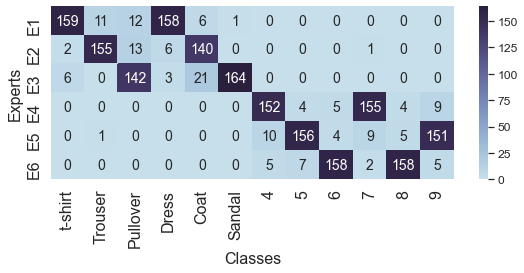


Split: [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]]


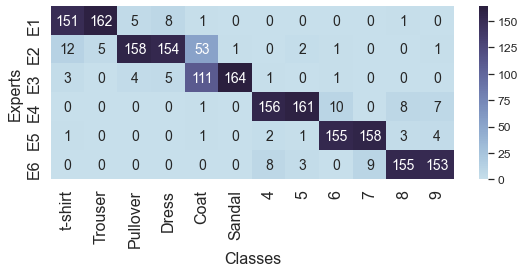


Split: [[0, 5], [1, 2], [3, 4], [6, 8], [7, 10], [9, 11]]


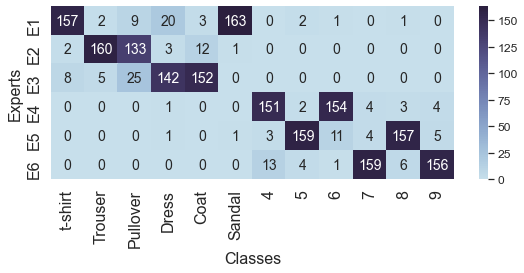

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_4 = 'fmnist_mnist_pretrained_gate_prechosen'

m = model_4
total_experts = 6
plot_file = generate_plot_file(m, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_prechosen = torch.load(open(os.path.join(pre_trained_model_path, 'fmnist', plot_file),'rb'), map_location=device)
print('Model:', plot_file)

for classes_per_expert, model in zip(classes_per_expert_list, models_prechosen):
    print('\nSplit:', classes_per_expert)
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        for images, labels in testloader:
            fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))
            images, labels = images.to(device), labels.to(device)
            moe_model = e_val['experts'][total_experts]['model']
            moe_model.device = device
            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs
            gate_outputs = moe_model.gate_outputs

            pred_gate_labels = torch.argmax(gate_outputs, dim=1)

            class_expert_table = np.asarray([[0] * num_classes]*total_experts)
            for label, expert in zip(labels, pred_gate_labels):
                class_expert_table[expert,label] += 1
            sns. set(font_scale=1.1)
            sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                        xticklabels=classes_fmnist_mnist,annot=True, cmap=cmap, fmt='d', annot_kws={"size": 14}, ax=ax1)
            ax1.set_xlabel('Classes', fontsize=16)
            ax1.set_ylabel('Experts',fontsize=16)
            ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=16, rotation=90)
            ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=16)
            image_file = generate_plot_file(m, specific='class_expert_table_'+classes_per_expert_str(classes_per_expert)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            plt.tight_layout()
            fig1.savefig(os.path.join(fig_path, image_file))
            plt.show()
    